# Performance Spectrum for Process Performance Analysis in Python
This Jupyter Notebook demonstrates how to use the Performance Spectrum for analyzing the process performance through Visual Analytics.

## Background: Performance Spectrum
The Performance Spectrum is a data structure and visualization of process event data for performance analysis over time. The Performance Spectrum only requires three attributes per event: case id, activity, timestamp, e.g.,
  - *(case1, A, t1)*
  - *(case1, B, t2)*
  - *(case1, A, t3)*
  - *(case1, B, t4)*
  - *(case1, C, t5)*
  - *(case2, A, t6)*
  - *(case2, B, t7)*

As common in Process Mining, the event stream above can be translated into sequences of timed events
  - *case1: (A,t1), (B,t2), (A,t3), (B,t4), (C,t5)*
  - *case2: (A,t6), (B,t7)*

The basic idea is to visualize a process not as a sequence/trace of events, but as a collection of segments.
A **segment (A,B)** is a pair of two activities/process steps in the process.

For a caseX where we observe two directly following events *caseX: ...(A,ti),(B,tj)...*, the Performance Spectrum data structure derives the **segment observation** *(caseX, A,B,ti,tj)*, i.e., *caseX* traversed segment *(A,B)* in the time-interval *(ti,tj)*. The above example has 3 observations of segment *(A,B)*: *(case1, A,B,t1,t2)*, *(case1, A,B,t3,t4)*, *(case2, A,B,t6,t7)*.

The Performance Spectrum visualization then plots all segment observations in (A,B) as a parallel-coordinates plot over time: time is mapped on the x-axis, each activity A,B,C,... etc is a parallel coordinate on the y axis, i.e., assigns coordinates y_A,y_B,y_C, etc. Each observation *(caseX, A,B,ti,tj)* is plotted as a line from *(ti,y_A)* to *(tj,y_B)*. Lines can be colored by user-chosen criteria, e.g., by duration *tj-ti* to reveal patterns.

## Getting Started
### Required software packages
  - The Performance Spectrum is a single Python file Performance_Spectrum.py. Download from ... and place it in your project directory.
  - Besides standard Python prerequisites matplotlib, pandas, numpy, the Performance Spectrum requires [pm4py](https://pm4py.org) for event log parsing, install it using `pip install pm4py`

### Required data for this notebook
  - Download the Road Traffice Fine Management Process event log https://doi.org/10.1007/s00607-015-0441-1, unzip and place the file "Road_Traffic_Fine_Management_Process.xes.gz" in the same directory as this Jupyter Notebook - or change the path to the file location on your disk

### Importing required packages

In [1]:
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np
from pm4py.objects.log.importer.xes import importer as xes_importer
%load_ext autoreload
%autoreload 2

%matplotlib inline
import Performance_Spectrum

## Read Log and Prepare Performance Spectrum
We first parse an `.xes` event log using pm4py and initialize the Performance Spectrum event data structure. In a second step, the data is translated into a Pandas dataframe. The visualization is then rendered from the dataframe directly (allowing to apply dataframe operations such as masking for exploring the Performance Spectrum).

In [2]:
# parse XES log into event stream - takes some time
rf_log = xes_importer.apply('Road_Traffic_Fine_Management_Process.xes')
# and parse into Performance Data event data structure (load time information)
rf = Performance_Spectrum.EventLog(name='roadfines', eventlog=rf_log)

parsing log, completed traces ::   0%|          | 0/150370 [00:00<?, ?it/s]

> Cleaning time zone information, adjust to 0.
> Found dates in event log ranging from 2000-01-01 01:00:00 to 2013-06-18 02:00:00.
> Done, continue with load_frame.


Set up the dataframe for the Performance Spectrum

In [3]:
# transform event data into dataframe, set maxdate=... to include only event up to maxdate, takes some time
rf.load_frame(maxdate=datetime.datetime(2001, 1, 1, 0, 0))
# transforms individual events in the dataframe (A,time1),(B,time2) into segment observations (A:B, [time1,time2])
rf.create_structure()
# clean out meta data to reduce size of dataframe
rf.remove_meta(to_keep=['start_totalPaymentAmount'])

> Creating Pandas DataFrame from event log, this might take a while...
> Done, continue with inspection of pf and create_structure
> Shifting log to generate case transitions.
> Adjusting time-grain to seconds.
> Done, continue with remove_meta to remove columns from pf and to correct naming.


Save our Event Log to disc using set name (here 'roadfines')

In [4]:
rf.save()

Load our Event Log object again (much faster than rebuilding)

In [5]:
rf = Performance_Spectrum.load_log('roadfines')

Lets inspect our data

In [6]:
rf.pf.head()

,case_id,start_org:resource,end_org:resource,start_time,end_time,segment_name,duration,segment_index,start_totalPaymentAmount
0,0.0,27,27,3553.0,5713.0,Create Fine complete - Send Fine complete,2160.0,0,0.00
1,0.0,27,27,5713.0,6169.0,Send Fine complete - Insert Fine Notification ...,456.0,1,NaN
2,0.0,27,27,6169.0,7608.0,Insert Fine Notification complete - Add penalt...,1439.0,2,NaN
3,0.0,27,27,7608.0,8160.0,Add penalty complete - Payment complete,552.0,3,NaN
4,0.0,27,27,8160.0,19921.0,Payment complete - Send for Credit Collection ...,11761.0,4,74.01


## Visualize Performance Spectrum Dataframe
  - Aggregation over all dataframe rows and columns, e.g. get the list of segments, count how many segment observations have been counted in each segment, etc.

In [7]:
# get statistics of total observations per segment, for all segments, sort by frequency
rf.segment_counts()

{'Create Fine complete - Send Fine complete': 11886,
 'Send Fine complete - Insert Fine Notification complete': 10887,
 'Insert Fine Notification complete - Add penalty complete': 9804,
 'Add penalty complete - Send for Credit Collection complete': 8931,
 'Create Fine complete - Payment complete': 3136,
 'Add penalty complete - Payment complete': 2040,
 'Payment complete - Add penalty complete': 916,
 'Insert Fine Notification complete - Payment complete': 914,
 'Send Fine complete - Payment complete': 498,
 'Payment complete - Payment complete': 478,
 'Insert Fine Notification complete - Send Fine complete': 313,
 'Create Fine complete - Insert Fine Notification complete': 313,
 'Send Fine complete - Add penalty complete': 307,
 'Payment complete - Send for Credit Collection complete': 260,
 'Insert Fine Notification complete - Insert Date Appeal to Prefecture complete': 190,
 'Insert Date Appeal to Prefecture complete - Add penalty complete': 146,
 'Add penalty complete - Send Appeal

  - compute the performance spectrum, i.e., all segment observations over all segments

In [8]:
# use the build in filter function to select segments
segments = rf.filter_segments(compare_to='max', cutoff=0.1)
segments

['Create Fine complete - Send Fine complete',
 'Send Fine complete - Insert Fine Notification complete',
 'Insert Fine Notification complete - Add penalty complete',
 'Add penalty complete - Send for Credit Collection complete',
 'Create Fine complete - Payment complete',
 'Add penalty complete - Payment complete']

In [9]:
# get the 6 most frequent segments
segments = list(rf.segment_counts().keys())[:6]
# compute the performance spectrum visualization
vis_rf = Performance_Spectrum.Spectrum(segments, rf.pf)

  - Visualize the Performance Spectrum on a subset of the segments, e.g., the most frequent segments, lines can be colored based on a class
    - classify line based on a mask, e.g. where time > 10,000
    - classify line based on equi-distant quantiles in a numeric *metric* attribute, e.g., *duration*
    - class_colors are defined using list of RGB-color codes per class, equi-distant quantiles for *metric* attribute are inputted in args=[]. Here we have 4 colors and thus 4 classes.

# Flavors of the Performance Spectrum

All as one color

> No classifier defined, vis_mask=False so no coloring based on mask, coloring eveything in first color!


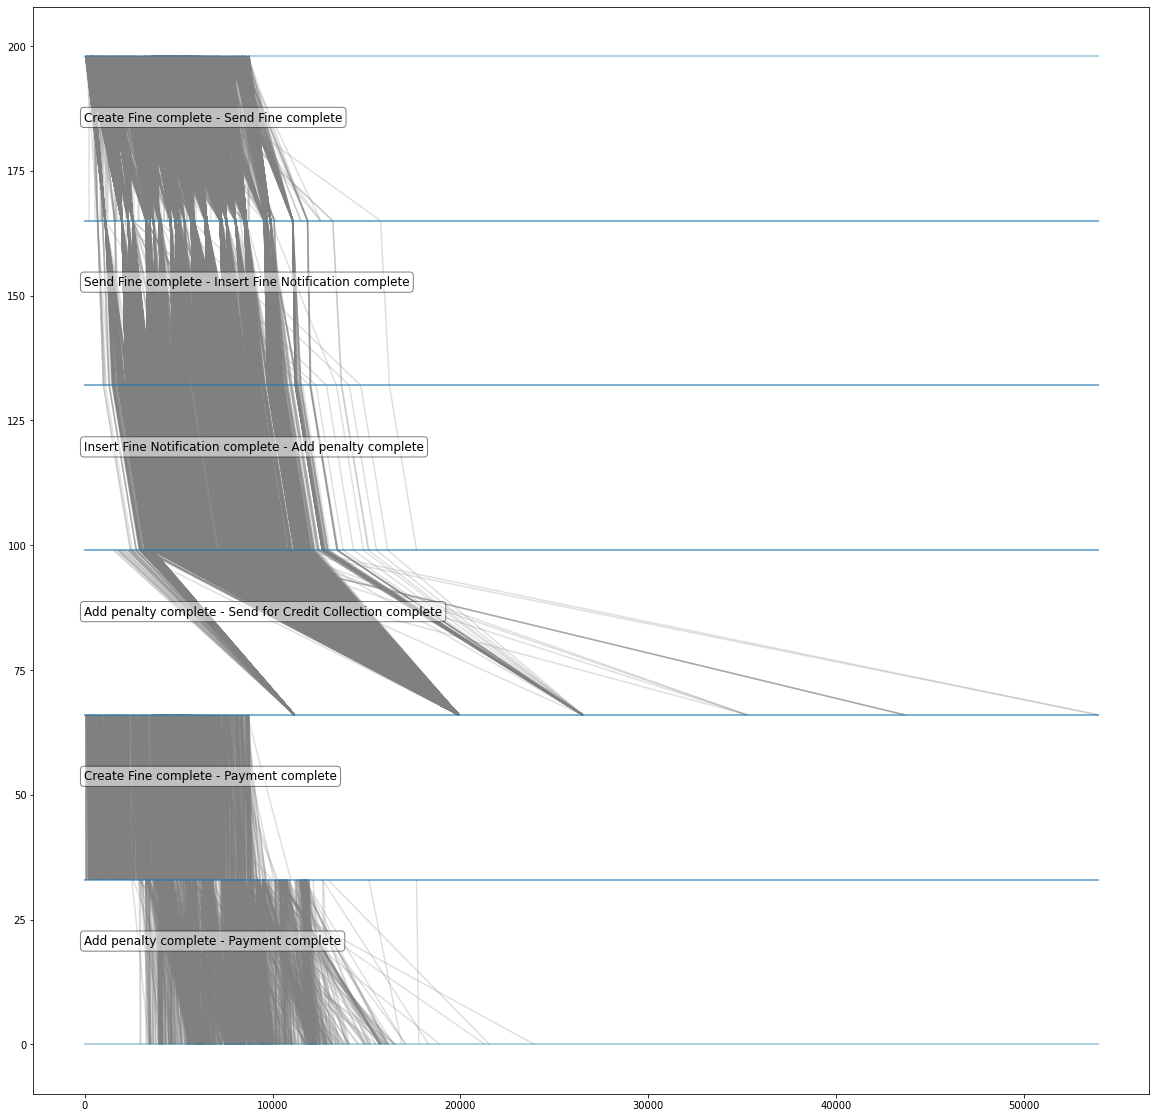

In [10]:
# define colors for class-based coloring of lines as list of RGB values: (R/256,G/256/B256)
# for performance-based classes, length of list defines number of quantiles
class_colors = [(0.5,0.5,0.5)]
# create plot
fig, ax = plt.subplots(figsize=[20,20])
# and visualize
vis_rf.plot_performance_spectrum(class_colors, ax, label_offset=-50)

Visualise a pandas mask

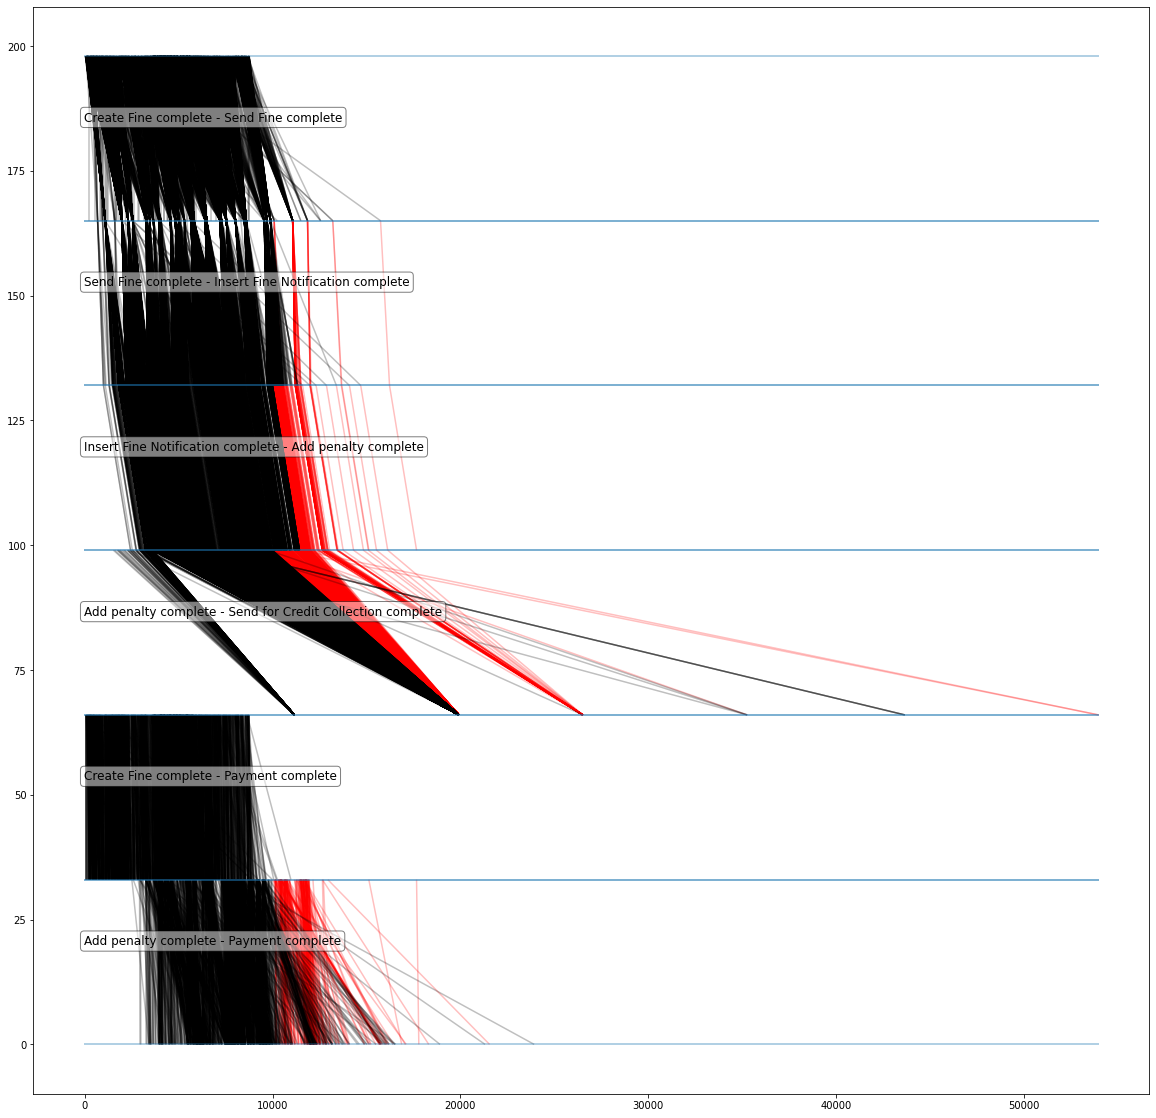

In [11]:
# define colors for class-based coloring of lines as list of RGB values: (R/256,G/256/B256)
# for performance-based classes, length of list defines number of quantiles
class_colors = [(0,0,0),(1,0,0)]
# create plot
fig, ax = plt.subplots(figsize=[20,20])
# and visualize, classifier is the provided mask, False gives first color (black) True gives second color (red)
vis_rf.plot_performance_spectrum(class_colors, ax, label_offset=-50, mask=vis_rf.pf['start_time'] > 10000, vis_mask=True)

OG Performance Spectrum coloring based on classifier=hist

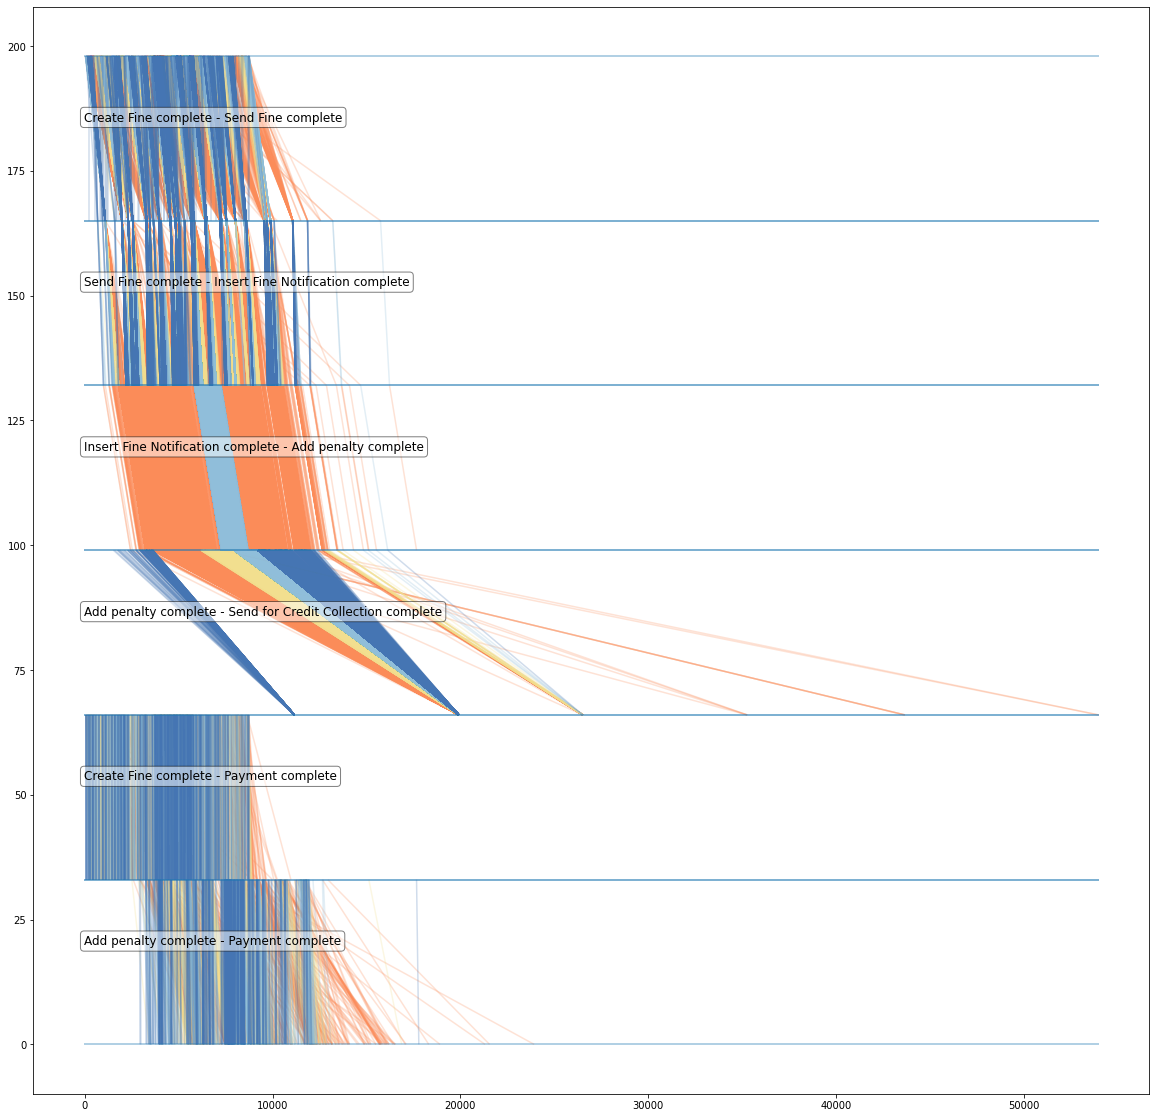

In [12]:
# define colors for class-based coloring of lines as list of RGB values: (R/256,G/256/B256)
# for performance-based classes, length of list defines number of quantiles
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]
# create plot
fig, ax = plt.subplots(figsize=[20,20])
# and visualize, classifier is histogram over 'duration' attribute into equi-distance (4) quantiles color by `class_colors`
vis_rf.plot_performance_spectrum(class_colors, ax, label_offset=-50, classifier=vis_rf.classify_hist, metric='duration', args=[4])

Only showing classes 0 and 1

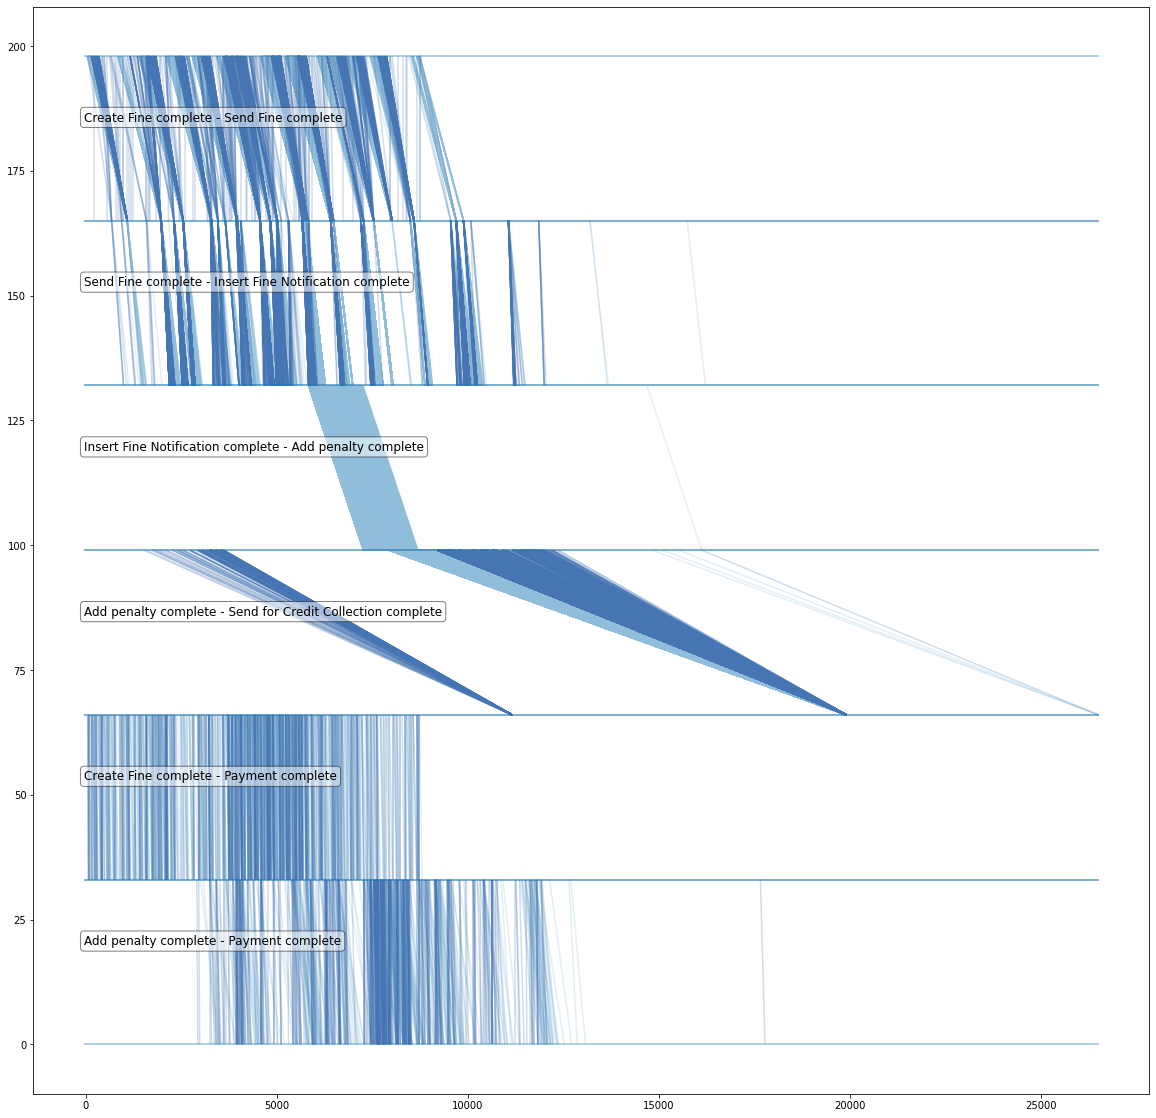

In [13]:
# define colors for class-based coloring of lines as list of RGB values: (R/256,G/256/B256)
# for performance-based classes, length of list defines number of quantiles
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]
# create plot
fig, ax = plt.subplots(figsize=[20,20])
# and visualize, classifier is histogram over 'duration' attribute into equi-distance (4) quantiles color by `class_colors`
vis_rf.plot_performance_spectrum(class_colors, ax, label_offset=-50, classifier=vis_rf.classify_hist, show_classes=[0,1], metric='duration', args=[4])

Other input to the Performance Spectrum:
- order='reversed', plot color layering the other way around (might help to tweak custom color plotting)
- compare='global' (default) vs compare='local'
    - Global -> apply classifier, then mask (e.g. classify all, and only show masked lines)
    - Local -> apply filter, then run classifier (e.g. only run the classifier on the leftover lines)
- exclude=mask, delete all data satisfying given mask before doing any other operations
- label_offset, how far the segment labels are plotted to the left (offset<0) or right (offset>0), tweak for nicer plots

## Use Dataframe Masks to Filter Events Before Computing Segments

In [14]:
# reload our event data (we keep more metadata this time)
rf.load_frame(maxdate=datetime.datetime(2001, 1, 1, 0, 0))
rf.create_structure()
# each segment has 2 activities, we can keep the meta data of both the start and end activity for a specific column like this:
rf.remove_meta(to_keep=['start_totalPaymentAmount', 'end_totalPaymentAmount'])

> Creating Pandas DataFrame from event log, this might take a while...
> Done, continue with inspection of pf and create_structure
> Shifting log to generate case transitions.
> Adjusting time-grain to seconds.
> Done, continue with remove_meta to remove columns from pf and to correct naming.


In [15]:
# we filter out any segment which does not have 'totalPaymentAmount' defined
rf.pf = rf.pf[(rf.pf['start_totalPaymentAmount']>=0) & (rf.pf['end_totalPaymentAmount']>=0)]

In [16]:
# get all segments
segments = list(rf.segment_counts().keys())
print(segments)

['Create Fine complete - Payment complete', 'Payment complete - Payment complete']


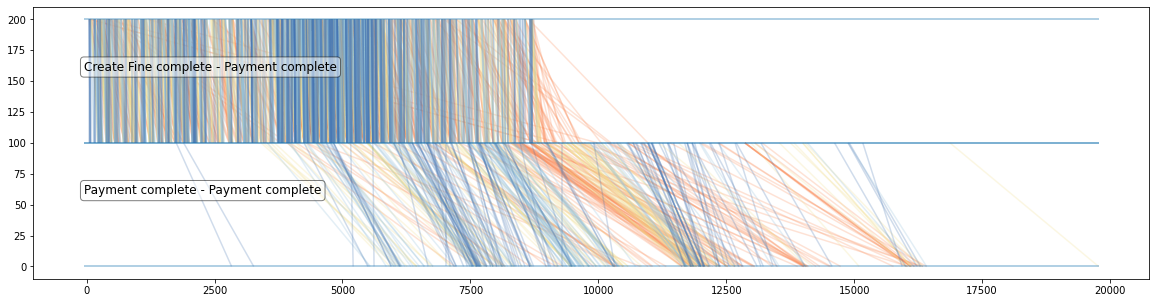

In [17]:
# compute the performance spectrum visualization
vis_rf = Performance_Spectrum.Spectrum(segments, rf.pf)
# define colors for class-based coloring of lines as list of RGB values: (R/256,G/256/B256)
# for performance-based classes, length of list defines number of quantiles
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]
# create plot
fig, ax = plt.subplots(figsize=[20,5])
# and visualize, classifier is histogram over 'duration' attribute into equi-distance quantiles based on `class_colors`
vis_rf.plot_performance_spectrum(class_colors, ax, label_offset=-50, classifier=vis_rf.classify_hist, metric='duration', args=[4])

## Use Dataframe Masks to filter out segments

In [23]:
# reload our earlier event data
rf = Performance_Spectrum.load_log('roadfines')

In [24]:
# get the 6 most frequent segments
segments = list(rf.segment_counts().keys())
# but filter out any "Appeal"-related activities, i.e., the events are removed from the data
# the segments in the performance spectrum then "jump over" all "Appeal"-related activities
segments_payment = [s for s in segments if "Payment" in s]
print(segments_payment)

['Create Fine complete - Payment complete', 'Add penalty complete - Payment complete', 'Payment complete - Add penalty complete', 'Insert Fine Notification complete - Payment complete', 'Send Fine complete - Payment complete', 'Payment complete - Payment complete', 'Payment complete - Send for Credit Collection complete', 'Payment complete - Send Fine complete', 'Payment complete - Insert Fine Notification complete', 'Notify Result Appeal to Offender complete - Payment complete', 'Send Appeal to Prefecture complete - Payment complete', 'Insert Date Appeal to Prefecture complete - Payment complete', 'Appeal to Judge complete - Payment complete']


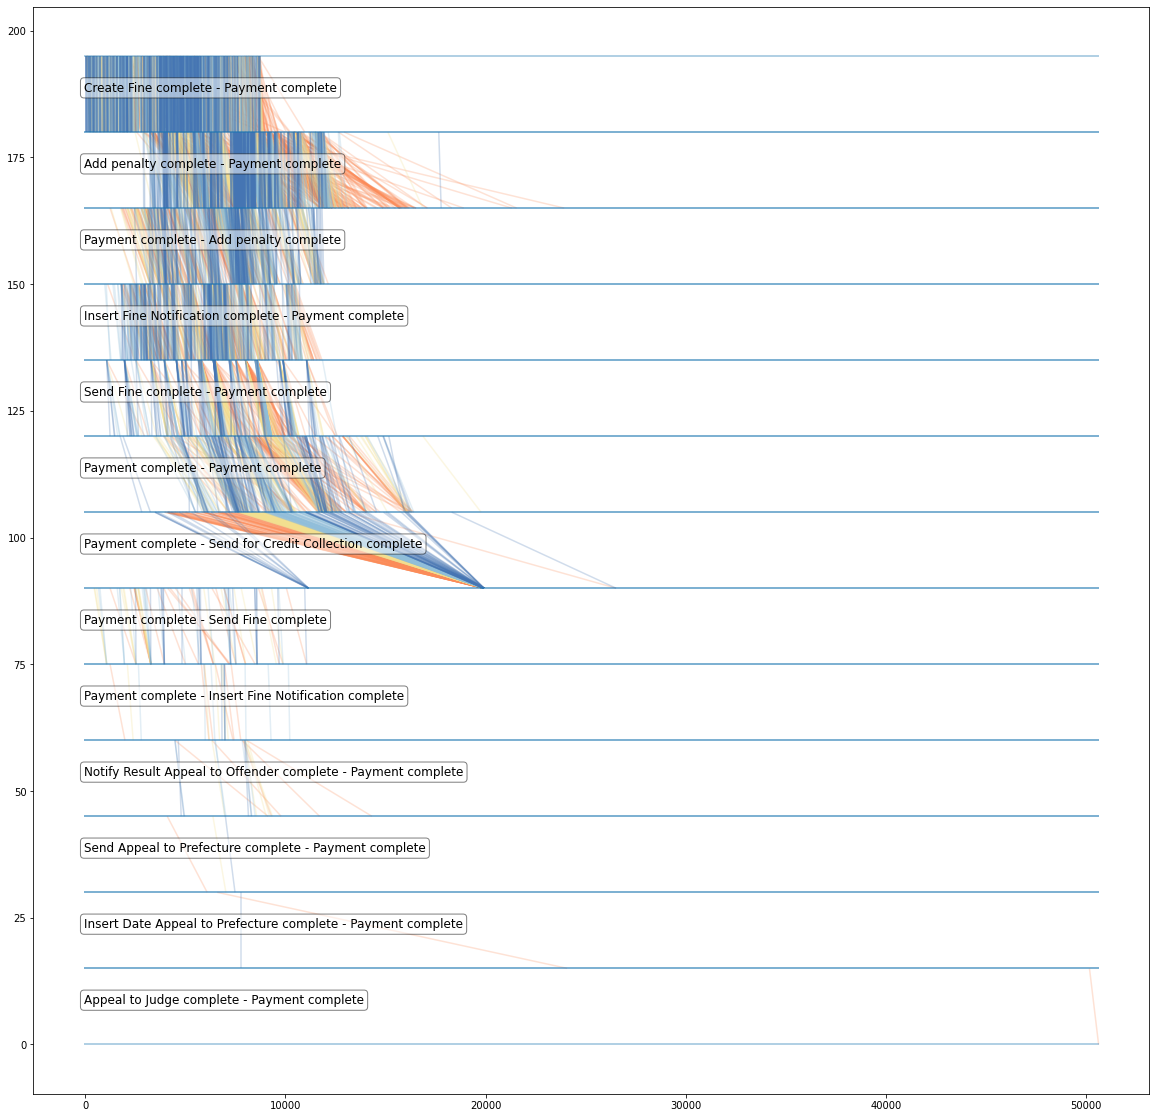

In [25]:
# compute the performance spectrum visualization
vis_rf = Performance_Spectrum.Spectrum(segments_payment, rf.pf)
# define colors for class-based coloring of lines as list of RGB values: (R/256,G/256/B256)
# for performance-based classes, length of list defines number of quantiles
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]
# create plot
fig, ax = plt.subplots(figsize=[20,20])
# and visualize, classifier is histogram over 'duration' attribute into equi-distance quantiles based on `class_colors`
vis_rf.plot_performance_spectrum(class_colors, ax, label_offset=-50, classifier=vis_rf.classify_hist, metric='duration', args=[4])

## Infer Missing Start Times and Analyze Service Times
Performance analysis for a segment (A,B) often requires to distinguish between the waiting time between A and B (the case was compelted by A and was waiting to be picked up at B), and service time (the case was actually worked on at B).

Most event logs only contain the completion times of an activity, so the actual time when B started to work on the case is missing.

The Performance Spectrum implementation allows to derive the the earliest possible start time for an activity based on the resource information in the event data.
  - Suppose activity A in caseX was completed at time tA by resource R
  - Resource R itself is working on various activities other cases
  - Assume the very last activity that R completed before tA was activity B at time tB in some caseY, i.e., tB < tA
  - Then R could have started working on A in caseX at earliest at time tB
  - Infer tB as the start timestamp for activity A in caseX using *infer_start_times()*

The operation creates a new Performance Spectrum dataframe with inferred timestamps that can be visualized as before.

In [26]:
# create new dataframe with start times inferred
pf_inferred = rf.infer_start_times()
# get all segment names
segments = pf_inferred['segment_name'].unique()
# and derive performance spectrum for
vis_inferred = Performance_Spectrum.Spectrum(segments, pf_inferred)

The resulting segments do not describe transitioning from one activity A to the next activity B, but show (A-start,A-complete), i.e., transitioning from starting an activity A to completing an activity A.

These segments can be visualized as performance spectrum as before.

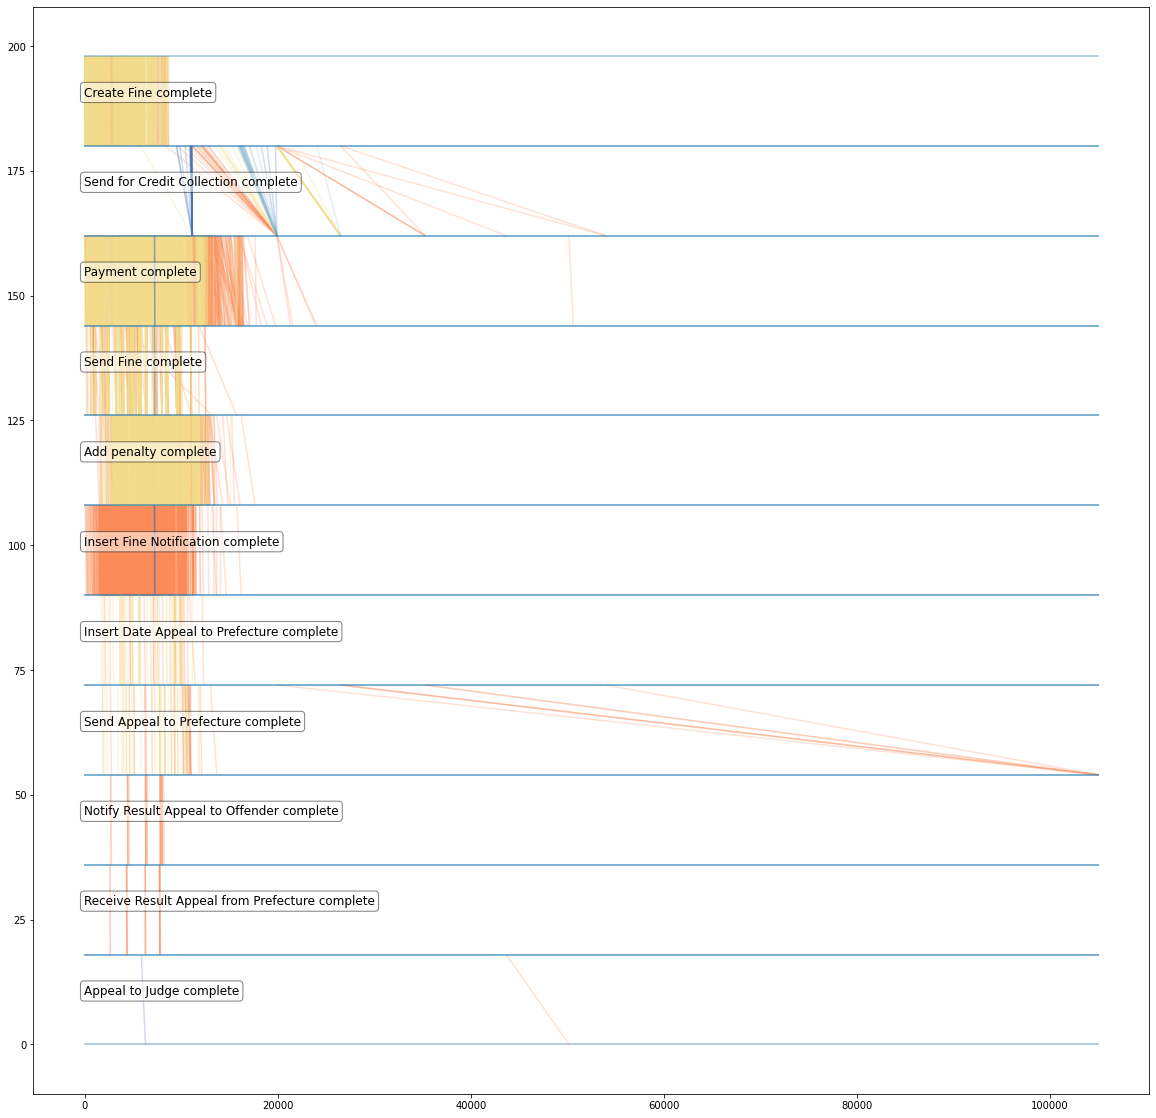

In [27]:
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]
fig, ax = plt.subplots(figsize=[20,20])
vis_inferred.plot_performance_spectrum(class_colors, ax, label_offset=-50, classifier=vis_inferred.classify_hist, metric='duration', args=[4])